# User analysis

---
This notebook provides general information and analysis on Style lend's users. This analysis provides insights for further model development and market analysis. 

Particulary, the following questions have been addressed.
- How many new users come into StyleLend each year? How many of them become lenders or renters.
- What are the most popular brands on website?
- How much users spend on Style Lend? How much lenders earn on Style Lend?
- How much is the revenue? Any seasonality?
- What information is provided by users?
- How do different user age groups perform?



In [35]:
% matplotlib inline
import matplotlib.pylab
import matplotlib.pyplot as plt


In [26]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
# set up the connection
dbname = 'mylocaldb' 
username = 'yangyang'

con = None
con = psycopg2.connect(database = dbname, user = username)

### How many registered users we have?

In [27]:
sql_query = """
SELECT *
FROM users
ORDER BY created_at DESC;
"""
users_all = pd.read_sql_query(sql_query,con)
#print("total number of users: {}".format(len(users_all)))

### How much is the revenue?

In [28]:
sql_query = """
SELECT rental_items.item_id, rental_items.item_price,
    items.user_id as lender_id,  items.created_at, 
    items.brand as item_brand, items.cost as item_cost,
    items.description,
    rentals.renter_id, rentals.rental_date,rentals.created_at as rental_created_at,
    rentals.id as rental_id
FROM items
LEFT JOIN rental_items
    ON items.id=rental_items.item_id
LEFT JOIN rentals
    ON rental_items.id = rentals.id

"""

df = pd.read_sql_query(sql_query,con)
df.head(1)


,item_id,item_price,lender_id,created_at,item_brand,item_cost,description,renter_id,rental_date,rental_created_at,rental_id
0,180.0,57.0,3,2014-01-26 03:05:09.666455,Rina Dhaka,350.0,This stunning dress brings back the summer. Th...,7744.0,2015-09-30,2015-09-13 20:32:31.642686,14.0


In [29]:
# rental_items = df[~df['renter_id'].isnull()]
# print("The total number of items = {}".format(len(df)))
# print("The total number of rented items = {}".format(sum(~df['rental_id'].isnull())))
# print("Total number of lenders = {}".format(len(df.lender_id.unique())))
# print("Total number of lenders whose items are rented ={}".format(len(rental_items.lender_id.unique())))

In [38]:
df['rental_datetime'] = df['rental_created_at'].apply(lambda x: pd.to_datetime(x,format = '%Y-%m-%d'))
df = df.set_index(df['rental_datetime'])
season_income = df.resample('BQ')['item_price'].agg({'count','sum'})
season_income.columns=['number_of_rented_items ','total_rent_price']
#season_income['count'].plot()
# plt.xlabel('Time',fontsize=20)
# plt.ylabel('Total rent cost ($)',fontsize=20)
# plt.title('Revenue, by quarter',fontsize=20)
season_income.head(1)

,number_of_rented_items,total_rent_price
rental_datetime,,
2015-09-30,2097.0,41


### Brand analysis

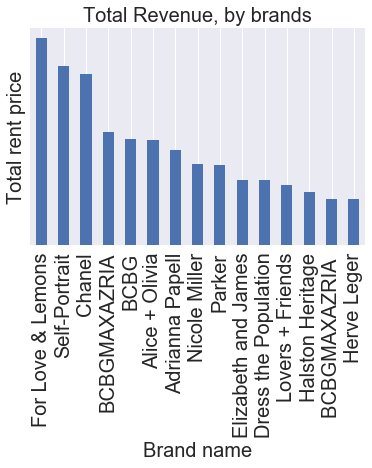

In [44]:
df['item_brand'] = df['item_brand'].apply(lambda x: 'Chanel' if 'Chanel' in x else x)
drop_indx = df[df['rental_id'].isnull()].index
rental_df = df.drop(drop_indx,axis=0)

def plot_item_price_by_brand(adf):
    f = {'item_brand':'count','item_price':'sum'}
    adf = adf.groupby(['item_brand'])[['item_brand','item_price']].agg(f).dropna()
    adf.columns = ['number_rented_items','total_rented_price']
    adf = adf.sort_values(['total_rented_price'],ascending=False)
    adf.ix[0:15,'total_rented_price'].plot(kind='bar',
                                            rot=90,
                                            fontsize=20,
                                           yticks=[]
                                            )
    plt.title('Total Revenue, by brands',fontsize=20)
    plt.ylabel('Total rent price',fontsize=20)
    plt.xlabel('Brand name',fontsize=20)
    
plot_item_price_by_brand(df)

### Super lenders in the pool

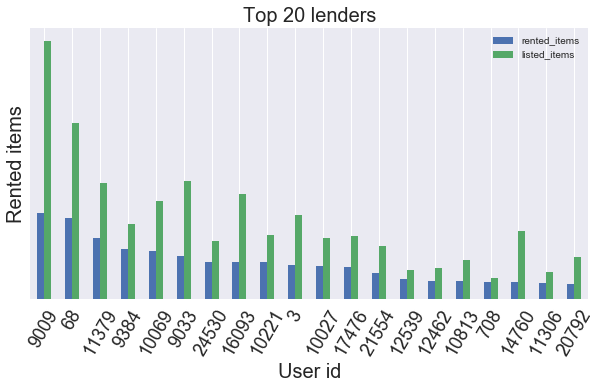

In [46]:
lenders_rental = rental_df.groupby(['lender_id'])[['lender_id']].count()
lenders_rental.columns=['rented_items']

lenders_listed = df.groupby(['lender_id'])[['lender_id']].count()
lenders_listed.columns=['listed_items']

lenders = lenders_rental.join(lenders_listed).sort_values(['rented_items'],ascending=False)
lenders[0:20].plot(kind='bar',fontsize=18,figsize=(10,5),rot=60,yticks=[])
plt.xlabel('User id',fontsize=20)
plt.ylabel('Rented items',fontsize=20)
plt.title('Top 20 lenders',fontsize=20)


## Renter analysis

In [48]:
# join rentals to users
sql_query = """
SELECT users.id as uid, users.created_at as u_created_at,users.date_of_birth, 
rentals.id as rental_id, rentals.created_at as rental_created_at, rentals.total_cost
FROM
users LEFT JOIN rentals
ON users.id=rentals.renter_id
"""
df = pd.read_sql_query(sql_query,con)

In [49]:
total_cost = df.groupby(['uid'])[['total_cost']].agg(['sum','count'])
total_cost.columns = ['total','number']
total_cost = total_cost.dropna()
total_cost = total_cost[total_cost['total']>0]
total_cost = total_cost.sort_values(by='total')


renters only use style lend one time: 622


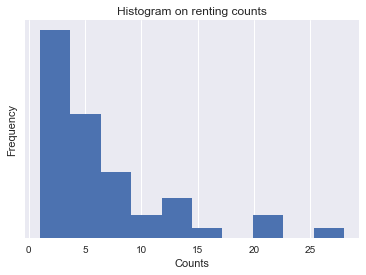

In [51]:
print('renters only use style lend one time: {}'.format(sum(total_cost['number']==1)))
# remove the top
total_cost = total_cost[total_cost['number']<40]
total_cost['number'].plot(kind='hist', logy=True,
                         title='Histogram on renting counts',yticks=[])
plt.xlabel('Counts')

### Renters from different age groups

In [58]:
# join rentals to users
sql_query = """
SELECT users.id as uid, users.created_at as u_created_at,users.date_of_birth, 
rentals.id as rental_id, rentals.created_at as rental_created_at, rentals.total_cost
FROM
users LEFT JOIN rentals
ON users.id=rentals.renter_id
"""
df = pd.read_sql_query(sql_query,con)


In [59]:
# the money each user spends on renting
f = {'total_cost':['sum','count'], 'date_of_birth':['first']}
total_spending = df.groupby(['uid'])['total_cost','date_of_birth'].agg(f)


In [60]:
total_spending.columns = ['money_spent','order_number','date_of_birth']

# total money spent from users w/ and w/out date of birth
tt_from_user_wo_dob = total_spending[total_spending['date_of_birth'].isnull()
                                    ].money_spent.sum()
tt_from_user_w_dob = total_spending[~total_spending['date_of_birth'].isnull()
                                   ].money_spent.sum()

print("total number of users = {}".format(len(total_spending)))
print("total number of users with date of birth = {}".
     format( sum(~total_spending.date_of_birth.isnull())) )
print("total number of renters = {}".format(sum(total_spending.order_number>0)))
print("total number of renters with date of birth = {}".
     format( sum((total_spending.order_number>0) & ~(total_spending.date_of_birth.isnull())) ))


print("total spending from users without dob = {0:.2f}"
      .format(tt_from_user_wo_dob))
print("total spending from users with dob = {0:.2f}"
      .format(tt_from_user_w_dob))

plt.figure(figsize=(6,6))
plt.pie([tt_from_user_w_dob,tt_from_user_wo_dob],
        explode=(0.01,0.05),autopct='%1.1f%%',
       labels=['users w/ date of birth', 'users without date of birth'])
plt.title('Among total ${0:.2f} renting cost'.format(tt_from_user_wo_dob+tt_from_user_w_dob))

TypeError: unsupported operand type(s) for +: 'datetime.date' and 'int'

In [64]:
# Analyze users with date of birth, consider the age range
from datetime import date

def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))


df_a = total_spending[~total_spending['date_of_birth'].isnull()]
df_a['date_of_birth'] = pd.to_datetime(df_a['date_of_birth'])
df_a = df_a[~df_a.date_of_birth.isnull()]
df_a = df_a.fillna(0)

def assign_age_range(s):
    # get the age range
    today = date.today()
    age = today.year - s.year
    if age<20:
        return "20 less"
    elif 20<=age<25:
        return "20~25"
    elif 25<=age<30:
        return "25~30"
    elif 30<=age<35:
        return "30~35"
    elif 35<=age<40:
        return "35~40"
    elif age>=40:
        return "40+"
    else:
        return "N/A"

df_a['age_range'] = df_a['date_of_birth'].apply(assign_age_range)


In [65]:
df_a = df_a.fillna(0)
stats = df_a.groupby(['age_range'])['money_spent'].agg(['sum', 'count', lambda column: sum(column!=0)])
stats.columns=['total_spent','number of users','number of renters']
stats['mean_spent'] = stats['total_spent'] / stats['number of renters']
stats['renter ratio'] = stats['number of renters'] / stats['number of users']

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(221)
stats[['number of users']].plot(kind='bar',ax = ax1,fontsize=18,legend=False)
ax1.set_title('Number of users',fontsize=18)


ax2 = fig.add_subplot(222)
stats[['renter ratio']].plot(kind='bar',ax = ax2, fontsize=18, legend=False)
ax2.set_title('Ratio of users becoming renters',fontsize=18)

ax3 = fig.add_subplot(223)
stats[['total_spent']].plot(kind='bar',ax = ax3, fontsize=18, legend=False)
ax3.set_title('Total spending from users',fontsize=18)

ax4 = fig.add_subplot(224)
stats[['mean_spent']].plot(kind='bar',ax = ax4, fontsize=18, legend=False)
ax4.set_title('Average spending from renters ($)',fontsize=18)

plt.tight_layout()

TypeError: unsupported operand type(s) for +: 'datetime.date' and 'int'

## The age distribution of users

([<matplotlib.patches.Wedge at 0x11d2d7748>,
  <matplotlib.text.Text at 0x11d2f05f8>])

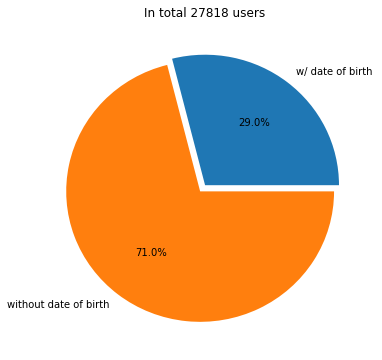

In [25]:
date_of_birth = pd.to_datetime(users_all.date_of_birth).dropna()

num_w_dob = len(date_of_birth)
num_wo_dob = len(users_all) - num_w_dob

plt.figure(1, figsize=(6,6))
plt.title('In total {} users'.format(len(users_all)))
plt.pie([num_w_dob,num_wo_dob],explode = (0.01,0.05),
        autopct='%1.1f%%', 
        labels=['w/ date of birth','without date of birth'])


In [41]:
date_of_birth = date_of_birth[date_of_birth>'1930-01-01']

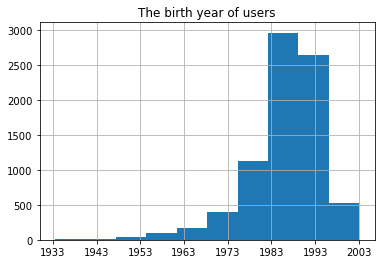

In [43]:
date_of_birth.hist()
plt.title('The birth year of users')

END